# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "marius"
ln1 = "ortega"
fn2 = "wiam"
ln2 = "adnan"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_ortega_marius_and_adnan_wiam.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.sparse.linalg import cg
from scipy.sparse import issparse, csr_matrix

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


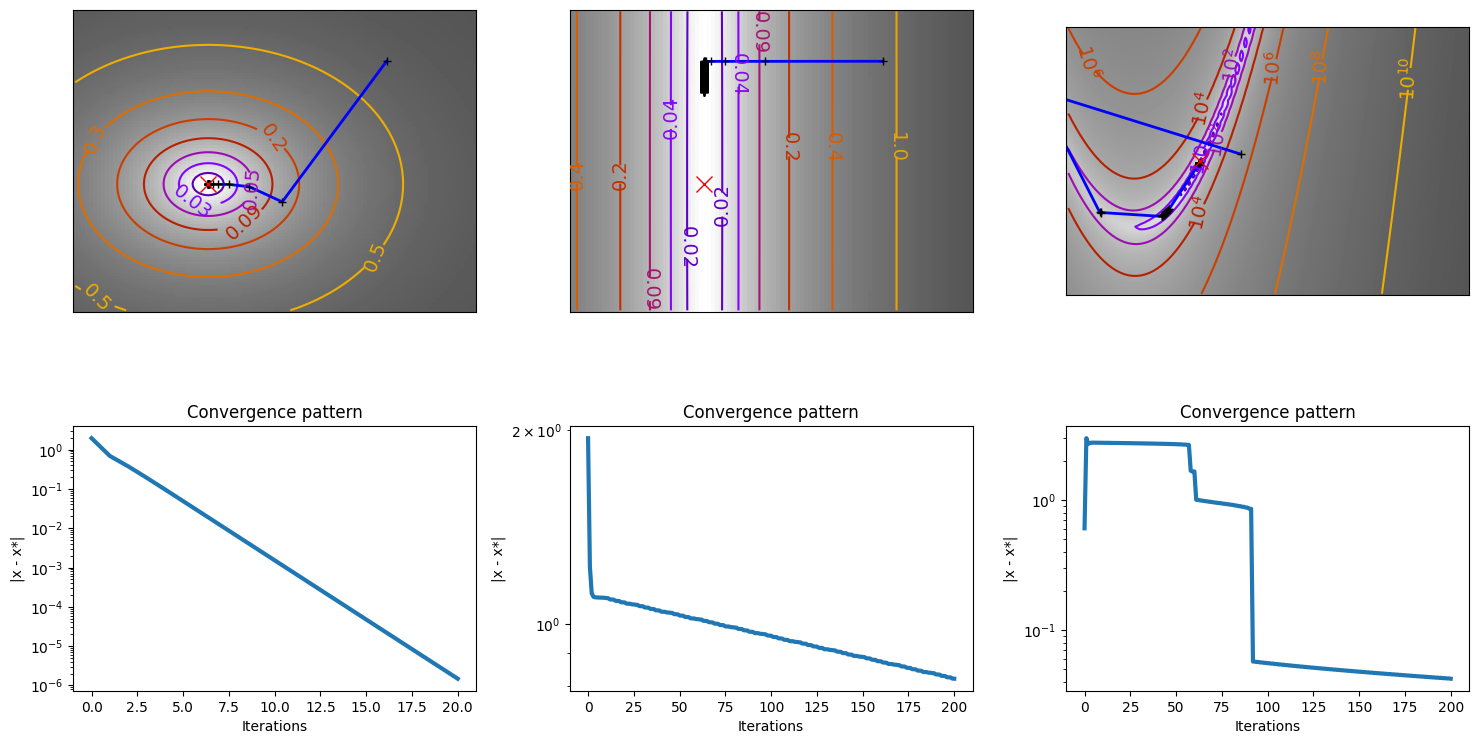

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [6]:
from scipy import linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO H = ..
        H = f_hessian(x)
        lambda_min = np.linalg.eigvals(H).min()
        if lambda_min < lambda_threshold: # regularization : if the smallest eigenvalue is too small, we make it larget so the hessian is semi definite positive
            H += (lambda_threshold - lambda_min) * np.eye(H.shape[0])
        
        d = -cg(H, grad_x)[0] # Solve the linear system H*d = -grad_x using the conjugate gradient method
        
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


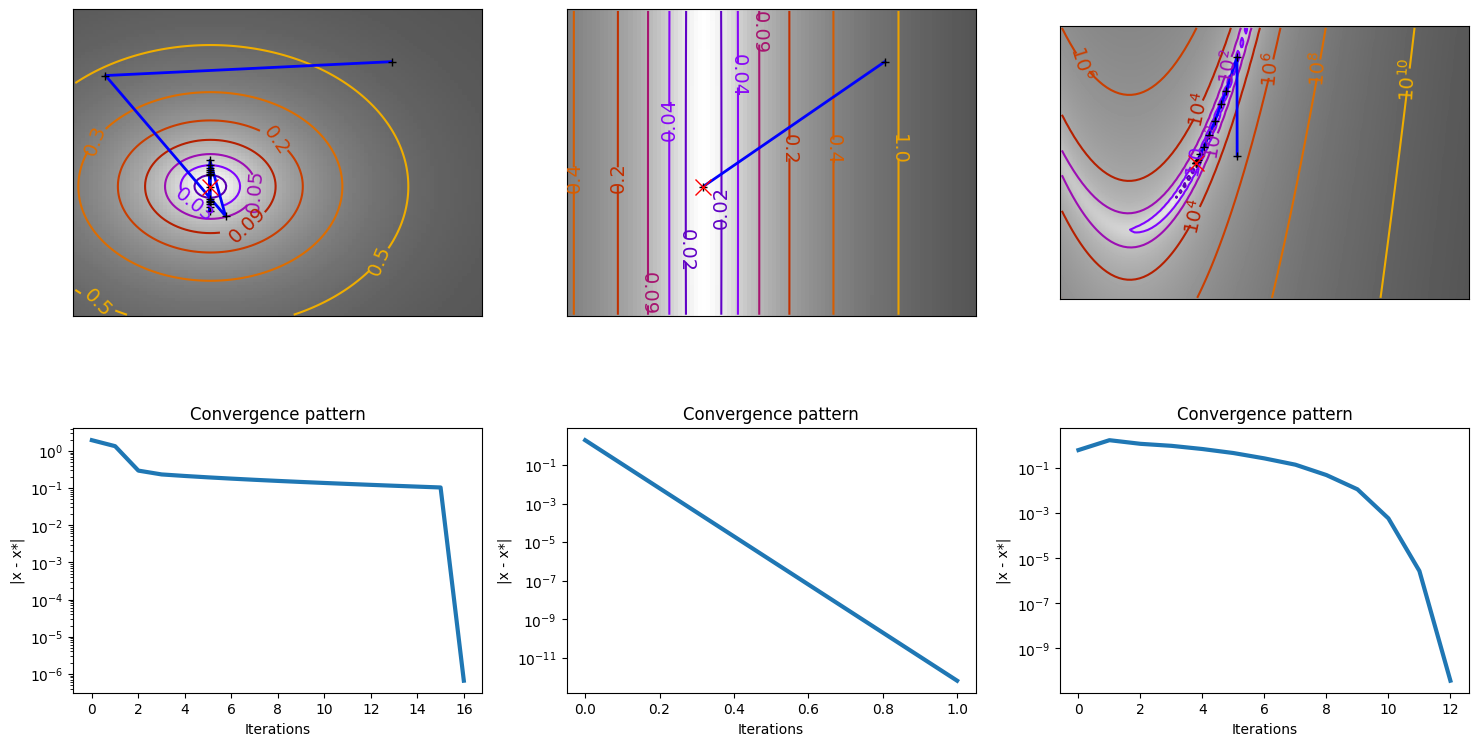

In [7]:
p = test_solver(newton)

### Regularization method :

In order to guarantee the good conditioning of the Hessian, we will use the following regularization:
$$
    H(x_k) \leftarrow H(x_k) + \alpha_k I
$$
where $\alpha_k$ is a coefficient calculated as follows : 
$$
    \alpha_k = \max(0, (\lambda_{threshold}-\lambda_{min}) * I_n)
$$

### Convergence Study :

Newton method theoretically locally converges quadratically when choosing the optimal $\gamma$: 
$$
    \|x_{k+1} - x^*\| \leq \gamma \|x_k - x^*\|^2
$$

Now let's look at each function and see if the convergence rate matches the theoretical results :
- For the Gaussian kernel : Indeed, the algorithm may diverge if the initial point is too far from the minimum or if the Hessian is non-positive definite. In our case, we regularized the Hessian to make it positive definite. However, we see that the initial point is relatively far from the aimed stationnary point, causing the algorithm to converge slower than quadratically. If it was farther away from the minimum, the algorithm would have diverged.
- For the badly conditioned and strongly convex quadratic function : the algorithm converges in one iteration. Indeed, the function is strongly convex and newton method doesn't depend on the conditioning of the problem. We can prove it as follows :

    For any quadratic function $f(x) = \frac{1}{2}x^\top Ax + b^\top x + c$ with $A$ symmetric positive definite, we have :
    $$
        \left\{
        \begin{align}
            & \nabla f(x) = Ax + b \\
            & \nabla^2 f(x) = A \\
            
        \end{align}
        \right.
        \Rightarrow
        x_{1} = x_0 - \nabla^2 f(x_0)^{-1} \nabla f(x_0) = x_0 - A^{-1}Ax_0 - A^{-1}b = A^{-1}bx^*, \text{ s.t } \nabla f(x^*) = 0
    $$
    Which proves the convergence in a single iteration.

- For the Rosenbrock function $f(x, y)=(a-x)^2 + b(y-x^2)^2$

    In comparison with the gradient descent, the Newton method converges very fast (Gradient descent didn't even converge).
    In the narrow valley of the Rosenbrock function, the Hessian might have one or more small eigenvalues, making it badly-conditioned (note that the Rosenbrock function is designed to challenge optimization algorithms). In our case, we chose an initial point sufficiently close to the minimum in a locally convex region which is why the algorithm still converges quadratically.
    

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        # TODO B = ...
        B += np.outer(s, s) / np.dot(s, y) - np.dot(np.dot(B, np.outer(y, y)), B) / np.dot(y, np.dot(B, y))

        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


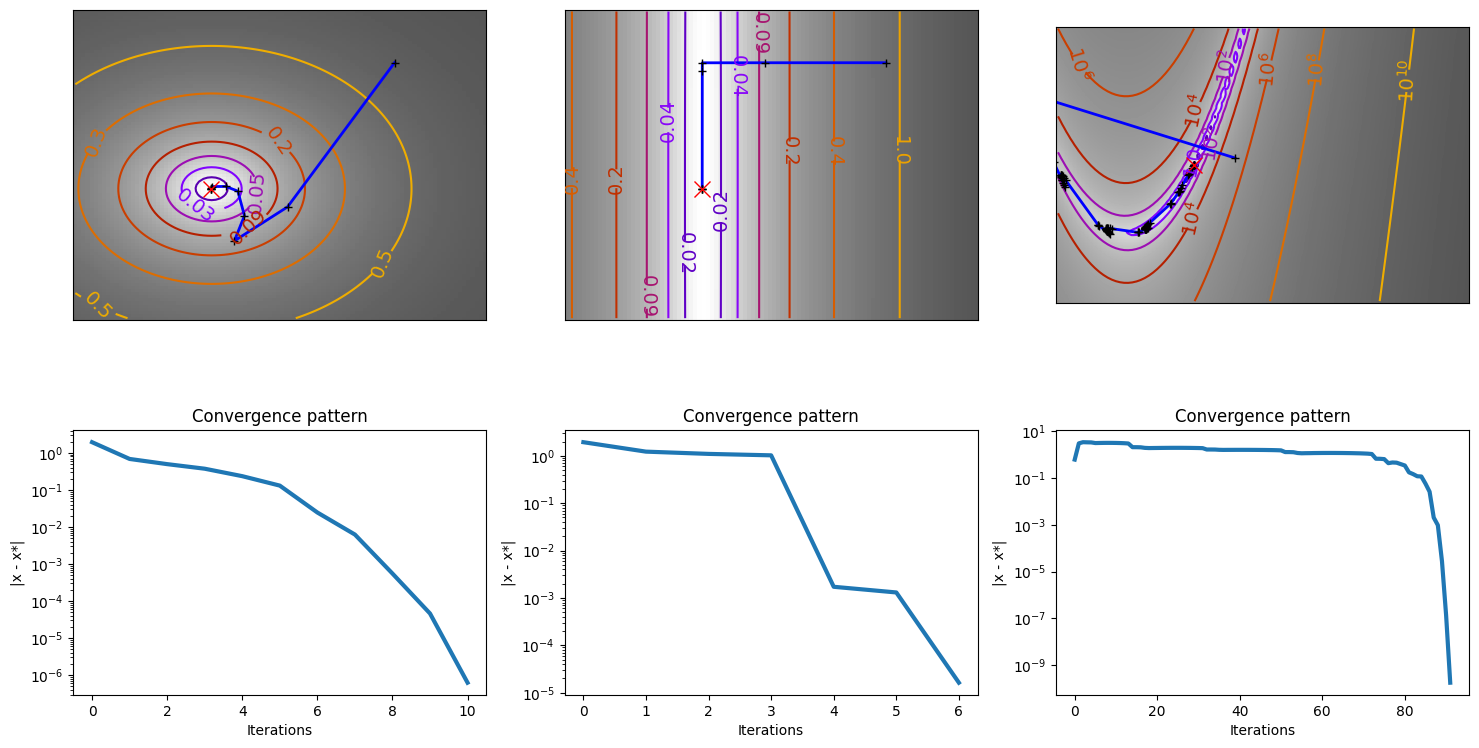

In [9]:
test_solver(dfp)

Note : At first, I tried to implement the DFP algorithm using naive python matricial product $s @ s_T$ however, $s$ is of shape $(n,)$ meaning its an array. To make the product work, we need to reshape $s$ to $(n, 1)$ which is the same as computing the outer product of $s$ with itself, which is the solution I used.

Let's analyze the convergence rate of the DFP algorithm :
-  For the non-convex Gaussian kernel $f(x) = -\exp(-\|x\|^2)$ :

    The DFP algorithm performs better than the Newton method. This is explained by the fact that DFP approximates the Hessian and doesn't use the exact one. Such a choice can lead to a faster convergence rate. In another setup, we aren't guaranteed to have a better convergence rate than Newton method.
     
- For the badly conditioned and strongly convex quadratic function :

    The first strange information we could denote is that the DFP algorithm doesn't converge in one iteration as the Newton method. However, this makes sense as DFP estimates the Hessian and doesn't use the exact one. 
    In the course material, the DFP convergence theorem garantees a convergence in at most $n$ iterations for quadratic functions considering that we use the optimal step size. Here, we have a "good" step size this no guarantee of it being optimal, which is why it might converge in more than $n$ iterations. That is what we observe here.
- For the Rosenbrock function :
    
    The DFP algorithm converges in $n$ iterations for quadratic functions. Still, Rosenbrock function can be locally approximated by a quadratic function, which is why we could obtain a convergence in $n$ iterations for an optimal step size. However, we don't have an optimal step size ($C_1$ and $C_2$ are not optimal) which is why we observe a convergence in more than $n$ iterations.

# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        #d = np.dot(B, -grad_x) #modification as this version is not working
        d = -linalg.solve(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = 
        B += np.outer(y, y) / np.dot(y, s) - np.dot(np.dot(B, np.outer(s, s)), B) / np.dot(s, np.dot(B, s))

        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


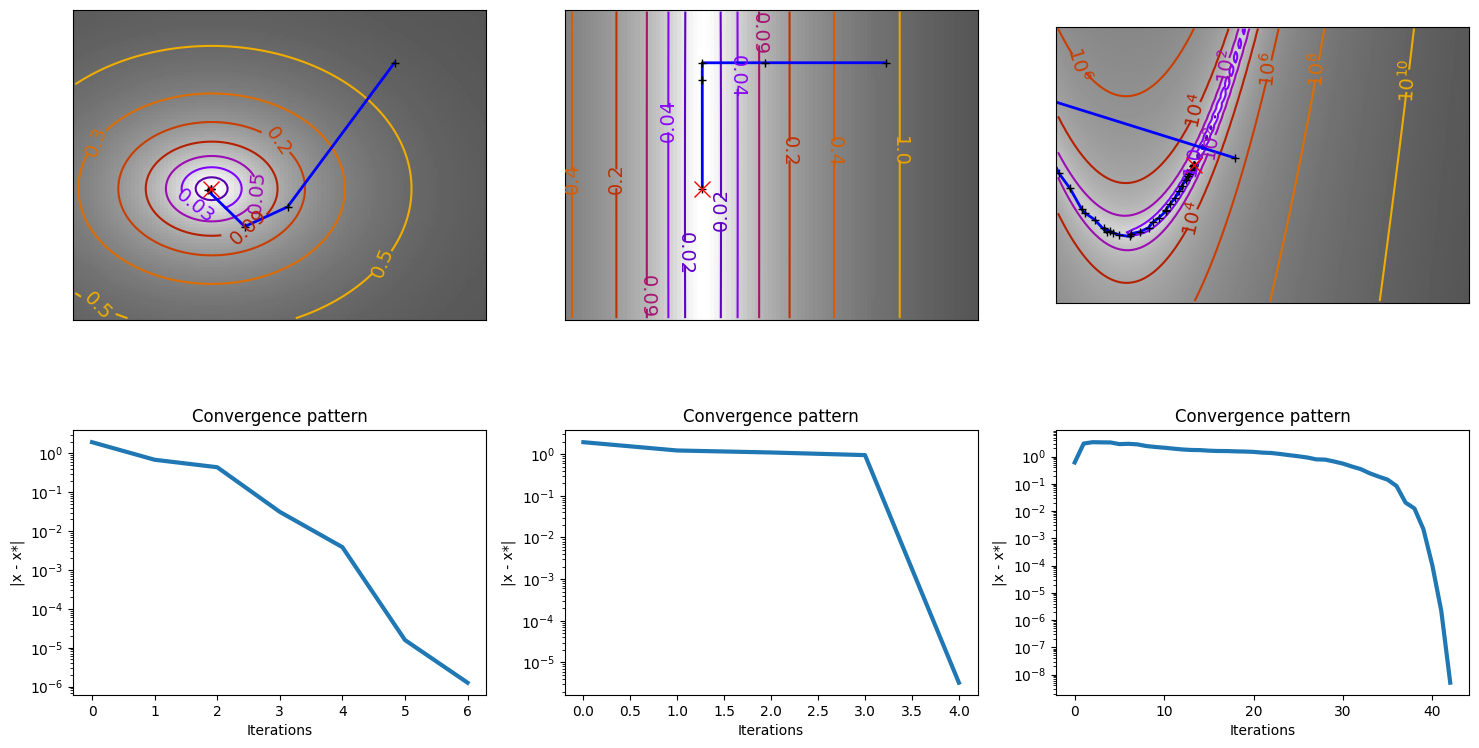

In [11]:
test_solver(bfgs)

Implementation-wise, LBFS is very similar to DFP. We only switch the roles of $s$ and $y$ in the formula for $H_t$, the Hessian approximation.
    $$
        H_{t+1} = H_t + \frac{y_t y_t^\top}{y_t^\top s_t} - \frac{H_t s_t s_t^\top H_t}{s_t^\top H_t s_t}
    $$
From the course, we know that, in the quadratic case, it converges in at most $n$ iterations with the optimal step size. In our case, we have a "good" step size with no guarantee of it being optimal which is why it might converge in more than $n$ iterations. Still, the convergence rate is better than DFP as the method is designed to be less sensitive to sub-optimal step size (our situation). 

Consequently, we almost observe the same converge rate as the DFP algorithm but with a slightly better performance thanks to its robustness to sub-optimal step size. 

# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [12]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    k = len(s_list)
    # TODO: first loop
    for i in reversed(range(k)):
        alpha = mu_list[i] * np.dot(s_list[i], q)
        q -= alpha * y_list[i]
        alpha_list.append(alpha)
    alpha_list.reverse()
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(k):
        beta = mu_list[i] * np.dot(y_list[i], r)
        r += s_list[i] * (alpha_list[i] - beta)
    return -r

In [13]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


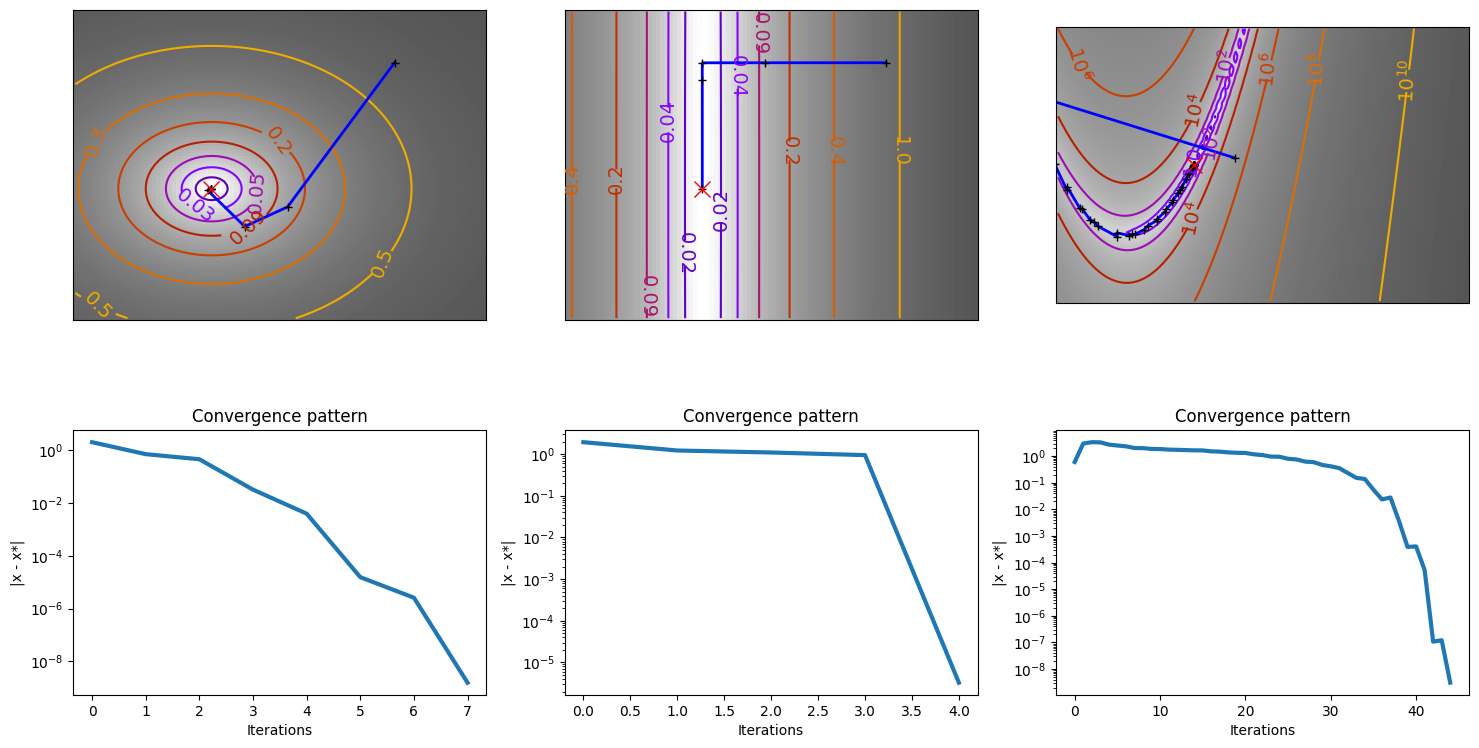

In [14]:
test_solver(lbfgs)

L-BFGS simply is a windowed version of BFGS method. Consequently, the convergence rate for the L-BFGS algorithm is the same (or almost the same) as the BFGS algorithm's one. However, the L-BFGS algorithm is more efficient in terms of memory and computation time. Indeed, the L-BFGS algorithm only needs to store the last $m$ pairs $(s_k, y_k)$ while LBFS stores the entire $n$ pairs of parameters.